# EELS SrFeO Project 
## RNN (supervised)

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on RNN

* <span style="color: red"> // put resources here // </span>

## Import Package

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False

In [19]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Convolution2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [5]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

<span style="color: red">** **Fake data for model eval** </span>

In [13]:
# fake dataset -- Trying to evaluate the model
import math
import numpy as np

M = 128 # number of energy channels
N = 10000 # number of datapoints
X,Y,U,W = list(),list(),list(),list()
data_1,data_2,data_3,data_4 = list(),list(),list(),list()

for k in range(round(N/2)): # datapoints doubles per iteration
    #np.random.seed(k)
    data_1.clear()
    data_2.clear()
    for i in np.arange(M):
        data_1.append(math.cos(float(i/64))+np.random.random()*2) # arbi function 1
        data_2.append(math.cos(float(i/64)*2)+np.random.random()*2) # arbi function 2
        data_3.append(math.cos(float(i/64))+1) # arbi function 1
        data_4.append(math.cos(float(i/64)*2)+1) # arbi function 2
    X.append(np.copy(data_1))
    Y.append([1,0])
    X.append(np.copy(data_2))
    Y.append([0,1])
    W.append(np.copy(data_3))
    U.append(np.copy(data_4))
#X = np.atleast_3d(np.array(X))
X = np.array(X)
Y = np.array(Y)
U = np.array(U)
W = np.array(W)

Text(0.5, 1.0, 'Autoencoder on fake data')

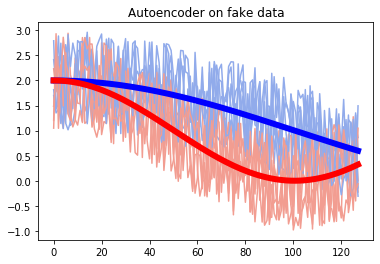

In [7]:
for i in range(0,10,2):
    plt.plot(X[i], color='#91abeb')
    plt.plot(X[i+1], color='#f29d91')
plt.plot(W[0], color='b', lw=6)
plt.plot(U[0], color='r', lw=6)
plt.title('Autoencoder on fake data')

In [14]:
# Shuffles data
X = np.atleast_3d(X)
placeholder = np.arange(X.shape[0])
np.random.shuffle(placeholder)
a,b = list(),list()
for i in placeholder:
    a.append(X[i])
    b.append(Y[i])
X=np.array(a)
Y=np.array(b)

In [15]:
# test-train split
length = 8000
ttsplit = 0.80 # ratio train to test sets
split = round(length*ttsplit)

x_train = np.atleast_3d(np.array(X[0:split]))
y_train = np.array(Y[0:split])
x_test = np.atleast_3d(np.array(X[split:length]))
y_test = np.array(Y[split:length])
x_validate = np.atleast_3d(np.array(X[length:]))
y_validate = np.array(Y[length:])

In [16]:
print(x_train.shape)
print(y_train.shape)

(6400, 128, 1)
(6400, 2)


In [17]:
print(x_test.shape)
print(y_test.shape)

(1600, 128, 1)
(1600, 2)


In [18]:
print(x_validate.shape)
print(y_validate.shape)

(2000, 128, 1)
(2000, 2)


## Recurrent Neural Network 

### Setting up RNN architecture

In [34]:
# model A:
N_encode = 4
l1_norm = 1e-4

model_A = Sequential()
model_A.add(LSTM(128, return_sequences=(N_encode > 1), dropout=0.02, input_shape=(128, 1)))
for i in range(1, N_encode):
    model_A.add(LSTM(128, return_sequences=(i < N_encode - 1), dropout=0.02))
model_A.add(Dense(2, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

### Choosing architecture

In [35]:
# set model
model = model_A

# or, load model & weight
'''
model.load_model("cnn_supervised_A_###.model")
model.load_weights("rnn_auto_checkpoints/weights.25-0.09173137.hdf5")
'''

'\nmodel.load_model("cnn_supervised_A_###.model")\nmodel.load_weights("rnn_auto_checkpoints/weights.25-0.09173137.hdf5")\n'

In [59]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 300, 300)          362400    
_________________________________________________________________
lstm_8 (LSTM)                (None, 300, 300)          721200    
_________________________________________________________________
lstm_9 (LSTM)                (None, 300)               721200    
_________________________________________________________________
encoding (Dense)             (None, 16)                4816      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 300, 16)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 300, 300)          380400    
_________________________________________________________________
lstm_11 (LSTM)               (None, 300, 300)         

### Compile model

In [463]:
# set learning rate
lr = 2e-3

# compile model
model.compile(optimizer=Adam(lr), loss='mse')
#model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy']) # categorical loss, Adam
#model.compile(loss='categorical_crossentropy', optimizer=SGD(lr), metrics=['accuracy']) # categorical loss, SGD

In [ ]:
#builds the filename
path = 'rnn_supvs_checkpoints'
filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'

# sets the control of checkpoints
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                             verbose=0, save_best_only=True,
                                             save_weights_only=True, 
                                             mode='min', period=1)

### Fits model

In [ ]:
# fits the model
model.fit(x_train, y_train, 
          epochs=100, batch_size=200, 
          validation_data=(x_test, y_test), 
          callbacks=[checkpoint])

Train on 19200 samples, validate on 4800 samples
Epoch 1/100
15000/19200 [======================>.......] - ETA: 23s - loss: 0.1154 - accuracy: 0.8637

### <span style="color:blue"> Training may take a few days depending on epochs and architecture. </span>
    At this point, just let the training run in the background. 
    Go to the next notebook to analyze the trained results.

### Evaluate the model

In [1]:
# Evaluation
scores = model.evaluate(x_validate,y_validate)

NameError: name 'model' is not defined

In [718]:
print("accuracy: ", round(scores[1]*100,4), "%")  # output Scalar accuracy
print("test loss: ", round(scores[0]*100,4), "%")  # output Scalar test loss

accuracy:  87.1833 %
test loss:  9.5932 %


In [711]:
# Predicted result 
y_predict_raw = model.predict(x_validate, verbose=1)

6000/6000 [==============================] - 19s 3ms/step


In [713]:
y_predict = list()
y_true = list()
for i in y_predict_raw:
    y_predict.append(list(i).index(max(i)))
for i in y_validate:
    y_true.append(list(i).index(max(i)))
y_predict = np.array(y_predict)
print("average prediction (should be 50%): "+str(round(np.average(y_predict)*2,2))+"%")

average prediction (should be 50%): 0.52%


[Text(24.0, 0.5, 'Actual'), Text(0.5, 24.0, 'Predicted')]

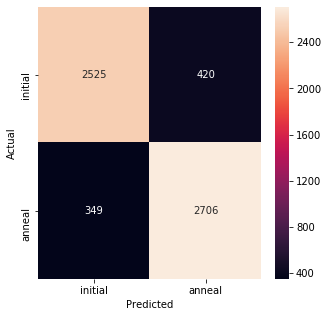

In [715]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(y_true, y_predict),
                     index = ["initial","anneal"],
                     columns = ["initial","anneal"])
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt="d")
ax.set(xlabel='Predicted', ylabel='Actual')

In [ ]:
import datetime
model.save('lstm_supervised_'+str(datetime.date.today())+'.model')

## RNN Plotting GIF

In [1033]:
# extracting data to np array
# O_range[5:26] is done to crop out the very top and very bottom of the image (as instructed in the SFO initial report)
data_comb = np.array([temporal_data[k].O_range for k in range(len(temporal_data))])

In [1034]:
data_comb.shape

(50, 12, 114, 300)

In [1035]:
np.average(data_comb[0][1:3,1:3], axis=(0,1)).shape

(300,)

In [1036]:
# Image Averaging 
win = 2 # averaging window size
new_y = data_comb.shape[1]-1
new_x = data_comb.shape[2]-1
temporal_for_analysis = np.zeros((data_comb.shape[0],new_y-1,new_x-1,data_comb.shape[3]))
for k,img in enumerate(data_comb):
    for y,x in itertools.product(range(1,new_y-1),range(1,new_x-1)):
        #print(y+win,x+win)
        temporal_for_analysis[k][y][x] = np.average(img[y:y+win,x:x+win], axis=(0,1))
print(temporal_for_analysis.shape)

(50, 10, 112, 300)


In [1039]:
# flattening data
temporal_for_analysis_flatten = temporal_for_analysis.reshape((-1, 300))

In [ ]:
# predict data
temporal_for_analysis_predict = model.predict(np.atleast_3d(temporal_for_analysis_flatten), verbose=1)

In [ ]:
temporal_for_analysis_predict.shape

In [ ]:
predict = list()
for i in temporal_for_analysis_predict:
    predict.append(list(i).index(max(i)))
predict = np.array(predict)

In [ ]:
predict.shape

In [ ]:
# reconstruct data
temporal_for_analysis_reconstruct = predict.reshape((50, 34, 112))

In [ ]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(36, 114))

def update(i):
    im_normed = temporal_for_analysis_reconstruct[i]
    ax.imshow(im_normed)
    ax.set_title("Angle: {}*pi/10".format(i), fontsize=20)
    ax.set_axis_off()

anim = FuncAnimation(fig, update, frames=np.arange(0, 50), interval=50)
anim.save('animation.gif', dpi=300, writer='tech tana')
